In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
from sklearn.metrics import root_mean_squared_error
from scipy.stats import bootstrap
import json
import mdtraj as md

In [2]:
sidechain_ensemble_dir = '../../data/af2chi_data/af2chi_runs_ILDNproteins/GB3/sidechain_ensemble_withH'

In [3]:
plot_names_dict = {'af2chi':'AF2χ', 'af2chi_prior':'AF2χ prior', 'charmm36m':'CHARMM36m', 'ff99sb':'ff99SB', 'ff99sb_ildn':'ff99SB-ILDN', 'af2_structure':'AF2 structure'}

In [4]:
for frame_idx in range(100):
    #print(frame_idx)
    frame = md.load(f'{sidechain_ensemble_dir}/struc_{frame_idx}.pdb', top=f'{sidechain_ensemble_dir}/struc_{frame_idx}.pdb')
    frame.time = frame_idx
    if frame_idx==0:
        ensemble_af2chi=frame 
    else:
        ensemble_af2chi = ensemble_af2chi.join(frame)

In [5]:
sidechain_ensemble_dir_norew = '../../data/af2chi_data/af2chi_runs_ILDNproteins/GB3/sidechain_ensemble_withH_norew'

for frame_idx in range(100):
    #print(frame_idx)
    frame = md.load(f'{sidechain_ensemble_dir_norew}/struc_{frame_idx}.pdb', top=f'{sidechain_ensemble_dir_norew}/struc_{frame_idx}.pdb')
    frame.time = frame_idx
    if frame_idx==0:
        ensemble_af2chi_prior=frame 
    else:
        ensemble_af2chi_prior = ensemble_af2chi_prior.join(frame)

In [6]:
def save_pickle(filename, pickle_obj):
    with open(filename, 'wb') as f:
        pkl.dump(pickle_obj, f)

def load_pickle(filename):
    with open(filename, 'rb') as f:
        loaded_obj = pkl.load(f)
        
    return loaded_obj

def load_json(file):
    with open(file, 'r') as f:
        loaded_json = json.load(f)
    return loaded_json

In [7]:
def karplus(karplus_coeffs, phi):
    A, B, C, delta = karplus_coeffs
    j3 = A*np.cos(phi+delta)*np.cos(phi+delta) + B*np.cos(phi+delta) + C
    return j3

In [8]:
#Val, Ile, Thr (C and N) from https://pubs.acs.org/doi/10.1021/ja029972s
#Rest from https://pubs.acs.org/doi/10.1021/ja003724j
karplus_coeffs_dict =  {'VAL_C': [3.42, -0.59, 0.17, np.deg2rad(5)],
                        'ILE_C': [3.42, -0.59, 0.17, np.deg2rad(5)],
                        'THR_C': [2.76, -0.67, 0.19, np.deg2rad(17)],
                        
                        'ASN_C': [2.31, -0.87, 1.37, 0],
                        'ASP_C': [2.31, -0.87, 1.06, 0],
                        'HIS_C': [2.31, -0.87, 0.98, 0],
                        'MET_C': [2.31, -0.87, 0.61, 0],
                        'ARG_C': [2.31, -0.87, 0.57, 0],
                        'GLU_C': [2.31, -0.87, 0.57, 0],
                        'GLN_C': [2.31, -0.87, 0.57, 0],
                        'LYS_C': [2.31, -0.87, 0.57, 0],
                        'PRO_C': [2.31, -0.87, 0.57, 0],
                        'LEU_C': [2.31, -0.87, 0.53, 0],
                        'PHE_C': [2.31, -0.87, 0.49, 0],
                        'TRP_C': [2.31, -0.87, 0.49, 0],
                        'TYR_C': [2.31, -0.87, 0.49, 0],
                        
                        'VAL_N': [2.64, 0.26, -0.22, np.deg2rad(6)],
                        'ILE_N': [2.64, 0.26, -0.22, np.deg2rad(6)],
                        'THR_N': [2.01, 0.21, -0.12, np.deg2rad(7)],
                        
                        'ASN_N': [1.29, -0.49, 0.89, 0],
                        'ASP_N': [1.29, -0.49, 0.70, 0],
                        'HIS_N': [1.29, -0.49, 0.65, 0],
                        'MET_N': [1.29, -0.49, 0.41, 0],
                        'ARG_N': [1.29, -0.49, 0.39, 0],
                        'GLN_N': [1.29, -0.49, 0.39, 0],
                        'GLU_N': [1.29, -0.49, 0.39, 0],
                        'LYS_N': [1.29, -0.49, 0.39, 0],
                        'LEU_N': [1.29, -0.49, 0.36, 0],
                        'PRO_N': [1.29, -0.49, 0.36, 0],
                        'PHE_N': [1.29, -0.49, 0.34, 0],
                        'TRP_N': [1.29, -0.49, 0.34, 0],
                        'TYR_N': [1.29, -0.49, 0.34, 0],
                        
                        'ALA_HAHB': [7.23, -1.37, 3.01, 0],
                        'ARG_HAHB': [7.23, -1.37, 2.40, 0],
                        'ASN_HAHB': [7.23, -1.37, 2.40, 0],
                        'ASP_HAHB': [7.23, -1.37, 2.40, 0],
                        'GLN_HAHB': [7.23, -1.37, 2.40, 0],
                        'GLU_HAHB': [7.23, -1.37, 2.40, 0],
                        'HIS_HAHB': [7.23, -1.37, 2.40, 0],
                        'LEU_HAHB': [7.23, -1.37, 2.40, 0],
                        'LYS_HAHB': [7.23, -1.37, 2.40, 0],
                        'MET_HAHB': [7.23, -1.37, 2.40, 0],
                        'PHE_HAHB': [7.23, -1.37, 2.40, 0],
                        'PRO_HAHB': [7.23, -1.37, 2.40, 0],
                        'TRP_HAHB': [7.23, -1.37, 2.40, 0],
                        'TYR_HAHB': [7.23, -1.37, 2.40, 0],
                        'ILE_HAHB': [7.23, -1.37, 1.79, 0],
                        'VAL_HAHB': [7.23, -1.37, 1.79, 0],
                        'CYS_HAHB': [7.23, -1.37, 1.71, 0],
                        'SER_HAHB': [7.23, -1.37, 1.42, 0],
                        'THR_HAHB': [7.23, -1.37, 0.81, 0],

                        'ALA_CHB': [4.02, -1.58, 1.71, 0],
                        'ARG_CHB': [4.02, -1.58, 1.41, 0],
                        'ASN_CHB': [4.02, -1.58, 1.41, 0],
                        'ASP_CHB': [4.02, -1.58, 1.41, 0],
                        'GLN_CHB': [4.02, -1.58, 1.41, 0],
                        'GLU_CHB': [4.02, -1.58, 1.41, 0],
                        'HIS_CHB': [4.02, -1.58, 1.41, 0],
                        'LEU_CHB': [4.02, -1.58, 1.41, 0],
                        'LYS_CHB': [4.02, -1.58, 1.41, 0],
                        'MET_CHB': [4.02, -1.58, 1.41, 0],
                        'PHE_CHB': [4.02, -1.58, 1.41, 0],
                        'PRO_CHB': [4.02, -1.58, 1.41, 0],
                        'TRP_CHB': [4.02, -1.58, 1.41, 0],
                        'TYR_CHB': [4.02, -1.58, 1.41, 0],
                        'ILE_CHB': [4.02, -1.58, 1.10, 0],
                        'VAL_CHB': [4.02, -1.58, 1.10, 0],
                        'CYS_CHB': [4.02, -1.58, 1.06, 0],
                        'SER_CHB': [4.02, -1.58, 0.91, 0],
                        'THR_CHB': [4.02, -1.58, 0.61, 0],
                                  }

In [9]:
def calc_C_CA_CB_CG_jcoupling(res_slice, atoms_line, karplus_coeffs):
    
    print(atoms_line)

    index_1 = res_slice.top.select('name C')[0]
    index_2 = res_slice.top.select('name CA')[0]
    index_3 = res_slice.top.select('name CB')[0]
    
    split_atom_names = atoms_line.split('_')[1]
    split_atom_names = [split_atom_names[0], split_atom_names[1:]]
    
    print(split_atom_names, split_atom_names[-1])

    if 'CG' == split_atom_names[-1]: 
        index_4 = res_slice.top.select('name CG')[0]

    elif 'CG1' == split_atom_names[-1]:
        index_4 = res_slice.top.select('name CG1')[0]

    elif 'CG2' == split_atom_names[-1]:
        index_4 = res_slice.top.select('name CG2')[0]
    else:
        raise Exception('No correct CG found')

    atom_idxs = np.array([index_1, index_2, index_3, index_4])
    
    angles = md.compute_dihedrals(res_slice, np.array([atom_idxs]))
    assert angles.shape[1] == 1
    angles = angles.flatten()

    j3_calc = karplus(karplus_coeffs, angles)
    j3_calc_avg = np.average(j3_calc)

    return j3_calc_avg


In [10]:
def calc_N_CA_CB_CG_jcoupling(res_slice, atoms_line, karplus_coeffs):
    
    print(atoms_line)

    index_1 = res_slice.top.select('name N')[0]
    index_2 = res_slice.top.select('name CA')[0]
    index_3 = res_slice.top.select('name CB')[0]
    
    split_atom_names = atoms_line.split('_')[1]
    split_atom_names = [split_atom_names[0], split_atom_names[1:]]

    print(split_atom_names)

    if 'CG' == split_atom_names[-1]: 
        index_4 = res_slice.top.select('name CG')[0]

    elif 'CG1' == split_atom_names[-1]:
        index_4 = res_slice.top.select('name CG1')[0]

    elif 'CG2' == split_atom_names[-1]:
        index_4 = res_slice.top.select('name CG2')[0]
    else:
        raise Exception('No correct CG found')

    atom_idxs = np.array([index_1, index_2, index_3, index_4])
    
    print(atom_idxs)
    angles = md.compute_dihedrals(res_slice, np.array([atom_idxs]))
    assert angles.shape[1] == 1
    angles = angles.flatten()
    print(angles)

    j3_calc = karplus(karplus_coeffs, angles)
    print(j3_calc.shape)
    print(j3_calc)

    j3_calc_avg = np.average(j3_calc)

    print(j3_calc_avg)

    return j3_calc_avg


In [11]:
def calc_HA_CA_CB_HB_jcoupling_OLD(res_slice, atoms_line, karplus_coeffs):
    
    index_1 = res_slice.top.select('name HA')[0]
    index_2 = res_slice.top.select('name CA')[0]
    index_3 = res_slice.top.select('name CB')[0]
    
    split_atom_names = atoms_line.split('_')[1::2]

    if 'HB' == split_atom_names[-1]: 
        index_4 = res_slice.top.select('name HB')[0]

    elif '1HB' == split_atom_names[-1]:
        index_4 = res_slice.top.select('name HB2')[0]

    elif '2HB' == split_atom_names[-1]:
        index_4 = res_slice.top.select('name HB3')[0]

    else:
        raise Exception('No correct HB found')
    
    atom_idxs = np.array([index_1, index_2, index_3, index_4])
    
    angles = md.compute_dihedrals(res_slice, np.array([atom_idxs]))
    assert angles.shape[1] == 1
    angles = angles.flatten()

    j3_calc = karplus(karplus_coeffs, angles)
    j3_calc_avg = np.average(j3_calc)


    return j3_calc_avg


In [12]:
def calc_HA_CA_CB_HB_jcoupling_OLD(res_slice, atoms_line, karplus_coeffs):
    
    index_1 = res_slice.top.select('name HA')[0]
    index_2 = res_slice.top.select('name CA')[0]
    index_3 = res_slice.top.select('name CB')[0]
    
    split_atom_names = atoms_line.split('_')[1::2]

    print(atoms_line)

    if 'HB' == split_atom_names[-1]: 
        index_4 = res_slice.top.select('name HB')[0]
    else:
        try: 
            res_slice.top.select('name HB3')[0]
            print('There is an HB3, so assuming HB2 HB3 naming')
            if '1HB' == split_atom_names[-1] or 'HB1' == split_atom_names[-1]:
                index_4 = res_slice.top.select('name HB2')[0]
            elif '2HB' == split_atom_names[-1] or 'HB2' == split_atom_names[-1]:
                index_4 = res_slice.top.select('name HB3')[0]
            else:
                raise Exception('No correct HB found')
        except:
            print('There is no HB3, so assuming HB1 HB2 naming')
            if '1HB' == split_atom_names[-1] or 'HB1' == split_atom_names[-1]:
                index_4 = res_slice.top.select('name HB2')[0]
            elif '2HB' == split_atom_names[-1] or 'HB2' == split_atom_names[-1]:
                index_4 = res_slice.top.select('name HB1')[0]
            else:
                raise Exception('No correct HB found')
    
    atom_idxs = np.array([index_1, index_2, index_3, index_4])
    
    angles = md.compute_dihedrals(res_slice, np.array([atom_idxs]))
    assert angles.shape[1] == 1
    angles = angles.flatten()

    j3_calc = karplus(karplus_coeffs, angles)
    j3_calc_avg = np.average(j3_calc)


    return j3_calc_avg


In [13]:
def calc_HA_CA_CB_HB_jcoupling(res_slice, atoms_line, karplus_coeffs):
    
    index_1 = res_slice.top.select('name HA')[0]
    index_2 = res_slice.top.select('name CA')[0]
    index_3 = res_slice.top.select('name CB')[0]
    
    split_atom_names = atoms_line.split('_')[1::2]

    if 'HB' == split_atom_names[-1]: 
        index_4 = res_slice.top.select('name HB')[0]

    elif '2HB' == split_atom_names[-1] or 'HB2' == split_atom_names[-1]:
        index_4 = res_slice.top.select('name HB2')[0]

    elif '3HB' == split_atom_names[-1] or 'HB3' == split_atom_names[-1]:
        index_4 = res_slice.top.select('name HB3')[0]
    else:
        raise Exception('No correct HB found')
    
    atom_idxs = np.array([index_1, index_2, index_3, index_4])
    
    angles = md.compute_dihedrals(res_slice, np.array([atom_idxs]))
    assert angles.shape[1] == 1
    angles = angles.flatten()

    j3_calc = karplus(karplus_coeffs, angles)
    j3_calc_avg = np.average(j3_calc)


    return j3_calc_avg


In [14]:
def get_atoms_lines(exp_j3_df, resnum):
    #Get rows of experimental data with resid
    row = exp_j3_df[exp_j3_df['resid'] == resnum]
    
    #Get the label with atoms (there can be multiple lines for one resid if there are multiple CG)
    atoms_lines = row['label'].values

    return atoms_lines

In [15]:
ensembles = {}

ensembles['af2chi'] = ensemble_af2chi
ensembles['af2chi_prior'] = ensemble_af2chi_prior
af2_structure = md.load('../../data/af2chi_data/af2chi_runs_ILDNproteins/GB3/af2_struc.pdb')
ensembles['af2_structure'] = af2_structure
charmm36m_traj = md.load('../../data/MD_data/MD_charmm36m/GB3.xtc', top='../../data/MD_data/MD_charmm36m/GB3.gro')
ensembles['charmm36m'] = charmm36m_traj


In [16]:
exp_j3_N_CA_CB_CG = pd.read_csv(f'../../data/jcouplings_expt/GB3_expt/GB3_NC_CA_CB_CG.txt', delim_whitespace=True, comment='#', names=['resid','label','exp','ff99sb','ff99sb_ildn'])
exp_j3_N_CA_CB_CG = exp_j3_N_CA_CB_CG[exp_j3_N_CA_CB_CG['label'].str.contains("NC")]


exp_j3_C_CA_CB_CG = pd.read_csv(f'../../data/jcouplings_expt/GB3_expt/GB3_NC_CA_CB_CG.txt', delim_whitespace=True, comment='#', names=['resid','label','exp','ff99sb','ff99sb_ildn'])
exp_j3_C_CA_CB_CG = exp_j3_C_CA_CB_CG[exp_j3_C_CA_CB_CG['label'].str.contains("CC")]

exp_j3_HA_CA_CB_HB = pd.read_csv(f'../../data/jcouplings_expt/GB3_expt/GB3_HA_CA_CB_HB.txt', delim_whitespace=True, comment='#', names=['resid','label','exp','ff99sb','ff99sb_ildn'])



/tmp/ipykernel_208352/3605385644.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  exp_j3_N_CA_CB_CG = pd.read_csv(f'../../data/jcouplings_expt/GB3_expt/GB3_NC_CA_CB_CG.txt', delim_whitespace=True, comment='#', names=['resid','label','exp','ff99sb','ff99sb_ildn'])
/tmp/ipykernel_208352/3605385644.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  exp_j3_C_CA_CB_CG = pd.read_csv(f'../../data/jcouplings_expt/GB3_expt/GB3_NC_CA_CB_CG.txt', delim_whitespace=True, comment='#', names=['resid','label','exp','ff99sb','ff99sb_ildn'])
/tmp/ipykernel_208352/3605385644.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  exp_j3_HA_CA_CB_HB = pd.read_csv(f'../../data/jcouplings_expt/GB3_expt/GB3_HA_CA_CB_HB.

In [17]:
j3_results = {}
#j3_results_reversedassignment = {}

for ensemble_type in ensembles.keys():
    
    traj = ensembles[ensemble_type]
    
    j3_vs_dihedraltype = {}
    #j3_vs_dihedraltype_reversedassignment = {}

    for residue in ensembles[ensemble_type].top.residues:
        residue = str(residue)
        #restype=residue[:3]
        #resnum=i+1 #int(residue[3:])

        resnum = int(''.join(filter(lambda x: x.isdigit(), residue)))
        restype = str(''.join(filter(lambda x: x.isalpha(), residue)))

        print(resnum)
        print(restype)
  
        C_karplus_params_available = True
        H_karplus_params_available = True
        N_karplus_params_available = True
        
        resatoms = traj.top.select(f'resi {resnum-1} and resname {restype}')

        if 'HIS' in restype:
            restype = 'HIS'
        print(resatoms)

        res_slice = traj.atom_slice(resatoms)
        print(list(res_slice.top.atoms))

        #Get Karplus parameters
        try:
            karplus_coeffs_HA_CA_CB_HB = karplus_coeffs_dict[f'{restype}_HAHB']
        except:
            print(f'No HAHB Karplus params for {restype}')
            H_karplus_params_available = False
        
        if H_karplus_params_available == True:
            atoms_lines_HA_CA_CB_HB = get_atoms_lines(exp_j3_HA_CA_CB_HB, resnum)
            
            #Loop over atoms for each resid
            for atoms_line in atoms_lines_HA_CA_CB_HB:
                print(atoms_line)
                j3_HA_CA_CB_HB= calc_HA_CA_CB_HB_jcoupling(res_slice, atoms_line, karplus_coeffs_HA_CA_CB_HB)
                #j3_HA_CA_CB_HB_reversedassignment = calc_HA_CA_CB_HB_jcoupling_reversedassignment(res_slice, atoms_line, karplus_coeffs_HA_CA_CB_HB)

                j3_vs_dihedraltype[f'{resnum}_{atoms_line}'] = j3_HA_CA_CB_HB
                #j3_vs_dihedraltype_reversedassignment[f'{resnum}_{atoms_line}'] = j3_HA_CA_CB_HB_reversedassignment

        #Get Karplus parameters
        try:
            karplus_coeffs_N_CA_CB_CG = karplus_coeffs_dict[f'{restype}_N']
        except:
            print(f'No N Karplus params for {restype}')
            N_karplus_params_available = False
        
        if N_karplus_params_available == True:
            atoms_lines_N_CA_CB_CG = get_atoms_lines(exp_j3_N_CA_CB_CG, resnum)
            
            #Loop over atoms for each resid
            for atoms_line in atoms_lines_N_CA_CB_CG:
                print(atoms_line)

                j3_N_CA_CB_CG = calc_N_CA_CB_CG_jcoupling(res_slice, atoms_line, karplus_coeffs_N_CA_CB_CG)
                #j3_N_CA_CB_CG_reversedassignment = calc_N_CA_CB_CG_jcoupling_reversedassignment(res_slice, atoms_line, karplus_coeffs_N_CA_CB_CG)

                j3_vs_dihedraltype[f'{resnum}_{atoms_line}'] = j3_N_CA_CB_CG
                #j3_vs_dihedraltype_reversedassignment[f'{resnum}_{atoms_line}'] = j3_N_CA_CB_CG_reversedassignment

        #Get Karplus parameters
        try:
            karplus_coeffs_C_CA_CB_CG = karplus_coeffs_dict[f'{restype}_C']
        except:
            print(f'No C Karplus params for {restype}')
            C_karplus_params_available = False
        
        if C_karplus_params_available == True:
            atoms_lines_C_CA_CB_CG = get_atoms_lines(exp_j3_C_CA_CB_CG, resnum)
            
            print(atoms_lines_C_CA_CB_CG)

            #Loop over atoms for each resid
            for atoms_line in atoms_lines_C_CA_CB_CG:
                print('Doing a C calculation')
                j3_C_CA_CB_CG = calc_C_CA_CB_CG_jcoupling(res_slice, atoms_line, karplus_coeffs_C_CA_CB_CG)
                #j3_C_CA_CB_CG_reversedassignment = calc_C_CA_CB_CG_jcoupling_reversedassignment(res_slice, atoms_line, karplus_coeffs_C_CA_CB_CG)

                j3_vs_dihedraltype[f'{resnum}_{atoms_line}'] = j3_C_CA_CB_CG
                #j3_vs_dihedraltype_reversedassignment[f'{resnum}_{atoms_line}'] = j3_C_CA_CB_CG_reversedassignment

    j3_results[ensemble_type] = j3_vs_dihedraltype
    #j3_results_reversedassignment[ensemble_type] = j3_vs_dihedraltype_reversedassignment

1
MET
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[MET1-N, MET1-H, MET1-H2, MET1-H3, MET1-CA, MET1-HA, MET1-CB, MET1-HB3, MET1-HB2, MET1-CG, MET1-HG3, MET1-HG2, MET1-SD, MET1-CE, MET1-HE1, MET1-HE2, MET1-HE3, MET1-C, MET1-O]
[]
2
GLN
[19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35]
[GLN2-N, GLN2-H, GLN2-CA, GLN2-HA, GLN2-CB, GLN2-HB3, GLN2-HB2, GLN2-CG, GLN2-HG3, GLN2-HG2, GLN2-CD, GLN2-OE1, GLN2-NE2, GLN2-HE21, GLN2-HE22, GLN2-C, GLN2-O]
[]
3
TYR
[36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56]
[TYR3-N, TYR3-H, TYR3-CA, TYR3-HA, TYR3-CB, TYR3-HB3, TYR3-HB2, TYR3-CG, TYR3-CD1, TYR3-HD1, TYR3-CE1, TYR3-HE1, TYR3-CZ, TYR3-OH, TYR3-HH, TYR3-CE2, TYR3-HE2, TYR3-CD2, TYR3-HD2, TYR3-C, TYR3-O]
HA_CA_CB_HB2
HA_CA_CB_HB3
[]
4
LYS
[57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78]
[LYS4-N, LYS4-H, LYS4-CA, LYS4-HA, LYS4-CB, LYS4-HB3, LYS4-HB2, LYS4-CG, LYS4-HG3, LYS4-HG2, LYS4-CD, LYS4-HD3, LYS4-HD2, LYS4-CE, LYS4-HE3, LYS4-HE2, LYS4-NZ, LYS4-

In [18]:
def make_plot_arrays_dict(j3_results_dict, exp_j3_df):

    j3_results_arrs = {}
    for ensemble_type in j3_results_dict.keys():
        ensemble_j3s = j3_results_dict[ensemble_type]

        ensemble_j3_arr = []
        for resnum, atoms_line in zip(exp_j3_df['resid'], exp_j3_df['label']):
            print(ensemble_type)
            print(resnum, atoms_line)
            ensemble_j3_arr.append(ensemble_j3s[f'{resnum}_{atoms_line}'])
        j3_results_arrs[ensemble_type] = np.array(ensemble_j3_arr)

    return j3_results_arrs


In [19]:
j3_results_arrs_N_CA_CB_CG = make_plot_arrays_dict(j3_results, exp_j3_N_CA_CB_CG)
j3_results_arrs_N_CA_CB_CG['ff99sb'] = np.array(exp_j3_N_CA_CB_CG['ff99sb'])
j3_results_arrs_N_CA_CB_CG['ff99sb_ildn'] = np.array(exp_j3_N_CA_CB_CG['ff99sb_ildn'])

j3_results_arrs_C_CA_CB_CG = make_plot_arrays_dict(j3_results, exp_j3_C_CA_CB_CG)
j3_results_arrs_C_CA_CB_CG['ff99sb'] = np.array(exp_j3_C_CA_CB_CG['ff99sb'])
j3_results_arrs_C_CA_CB_CG['ff99sb_ildn'] = np.array(exp_j3_C_CA_CB_CG['ff99sb_ildn'])

j3_results_arrs_HA_CA_CB_HB = make_plot_arrays_dict(j3_results, exp_j3_HA_CA_CB_HB)
j3_results_arrs_HA_CA_CB_HB['ff99sb'] = np.array(exp_j3_HA_CA_CB_HB['ff99sb'])
j3_results_arrs_HA_CA_CB_HB['ff99sb_ildn'] = np.array(exp_j3_HA_CA_CB_HB['ff99sb_ildn'])

#j3_results_arrs_HA_CA_CB_HB_reversedassignment = make_plot_arrays_dict(j3_results_reversedassignment, exp_j3_HA_CA_CB_HB)
#j3_results_arrs_HA_CA_CB_HB_reversedassignment['ff99sb'] = np.array(exp_j3_HA_CA_CB_HB['ff99sb'])
#j3_results_arrs_HA_CA_CB_HB_reversedassignment['ff99sb_ildn'] = np.array(exp_j3_HA_CA_CB_HB['ff99sb_ildn'])

af2chi
6 VAL_NCG1
af2chi
6 VAL_NCG2
af2chi
7 ILE_NCG2
af2chi
11 THR_NCG2
af2chi
16 THR_NCG2
af2chi
17 THR_NCG2
af2chi
18 THR_NCG2
af2chi
21 VAL_NCG1
af2chi
21 VAL_NCG2
af2chi
25 THR_NCG2
af2chi
39 VAL_NCG1
af2chi
39 VAL_NCG2
af2chi
42 VAL_NCG1
af2chi
42 VAL_NCG2
af2chi
44 THR_NCG2
af2chi
49 THR_NCG2
af2chi
51 THR_NCG2
af2chi
53 THR_NCG2
af2chi
54 VAL_NCG1
af2chi
54 VAL_NCG2
af2chi
55 THR_NCG2
af2chi_prior
6 VAL_NCG1
af2chi_prior
6 VAL_NCG2
af2chi_prior
7 ILE_NCG2
af2chi_prior
11 THR_NCG2
af2chi_prior
16 THR_NCG2
af2chi_prior
17 THR_NCG2
af2chi_prior
18 THR_NCG2
af2chi_prior
21 VAL_NCG1
af2chi_prior
21 VAL_NCG2
af2chi_prior
25 THR_NCG2
af2chi_prior
39 VAL_NCG1
af2chi_prior
39 VAL_NCG2
af2chi_prior
42 VAL_NCG1
af2chi_prior
42 VAL_NCG2
af2chi_prior
44 THR_NCG2
af2chi_prior
49 THR_NCG2
af2chi_prior
51 THR_NCG2
af2chi_prior
53 THR_NCG2
af2chi_prior
54 VAL_NCG1
af2chi_prior
54 VAL_NCG2
af2chi_prior
55 THR_NCG2
af2_structure
6 VAL_NCG1
af2_structure
6 VAL_NCG2
af2_structure
7 ILE_NCG2
af2_str

In [20]:
def make_plot(j3_exp_arr_C, j3_exp_arr_N, j3_exp_arr_HAHB, j3_ensemble_arr_C, j3_ensemble_arr_N, j3_ensemble_arr_HAHB, title, outfile):

    pltmax = np.amax([ *j3_exp_arr_C, *j3_exp_arr_N, *j3_exp_arr_HAHB, *j3_ensemble_arr_C, *j3_ensemble_arr_N, *j3_ensemble_arr_HAHB])
    pltmax += 0.1*pltmax
    pltmin = np.amin([*j3_exp_arr_C, *j3_exp_arr_N, *j3_exp_arr_HAHB, *j3_ensemble_arr_C, *j3_ensemble_arr_N, *j3_ensemble_arr_HAHB])
    pltmin -= 0.1*pltmax
    
    RMSE_C = root_mean_squared_error(j3_exp_arr_C, j3_ensemble_arr_C)
    RMSE_N = root_mean_squared_error(j3_exp_arr_N, j3_ensemble_arr_N)
    RMSE_HAHB = root_mean_squared_error(j3_exp_arr_HAHB, j3_ensemble_arr_HAHB)
    
    #Plotting
    fig = plt.figure(figsize=(4,4))

    plt.title(title, fontsize=15)
    
    plt.plot([-100,100], [-100,100], '--', color='black')

    plt.plot(j3_exp_arr_C, j3_ensemble_arr_C, 'o', c='black', markeredgecolor='black', label='C\'-Cα-Cβ-Cγ') #(RMSE={RMSE_C:.2})')
    plt.plot(j3_exp_arr_N, j3_ensemble_arr_N, 'o', c='ghostwhite', markeredgecolor='black', label='N-Cα-Cβ-Cγ') #(RMSE={RMSE_N:.2})')
    plt.plot(j3_exp_arr_HAHB, j3_ensemble_arr_HAHB, 'o', c='gray', markeredgecolor='black', label='Hα-Cα-Cβ-Hβ') #(RMSE={RMSE_HAHB:.2})')
    
    plt.xlabel('$^3J$ experiment (Hz)', fontsize=15)
    plt.ylabel('$^3J$ model (Hz)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=15)

    plt.xlim(pltmin, pltmax)
    plt.ylim(pltmin, pltmax)
    
    plt.legend(fontsize=15, bbox_to_anchor=(1,1.3), ncol=3)
    
    plt.savefig(outfile, bbox_inches='tight')

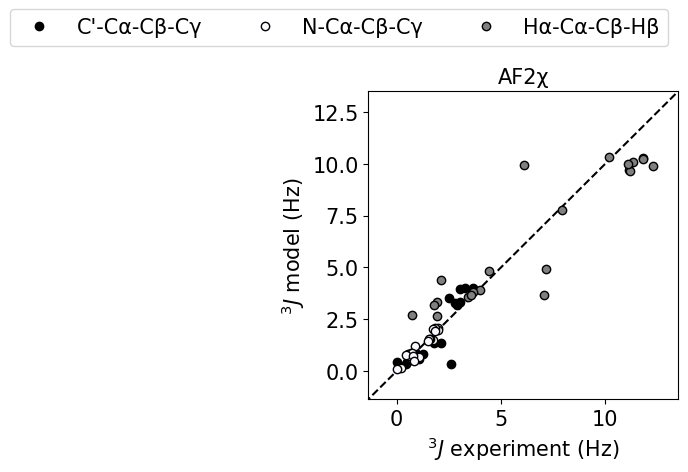

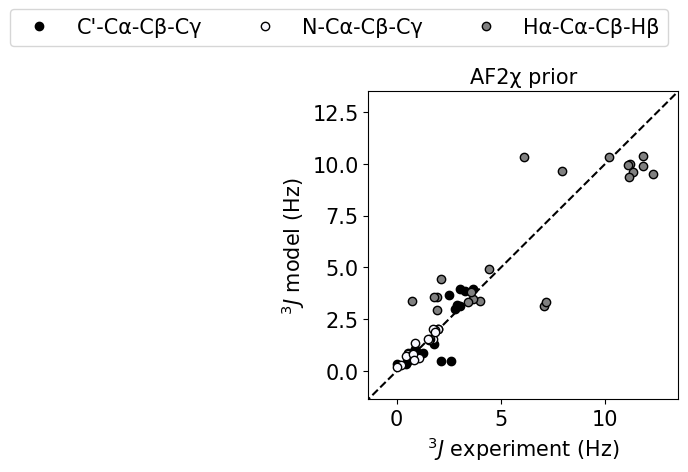

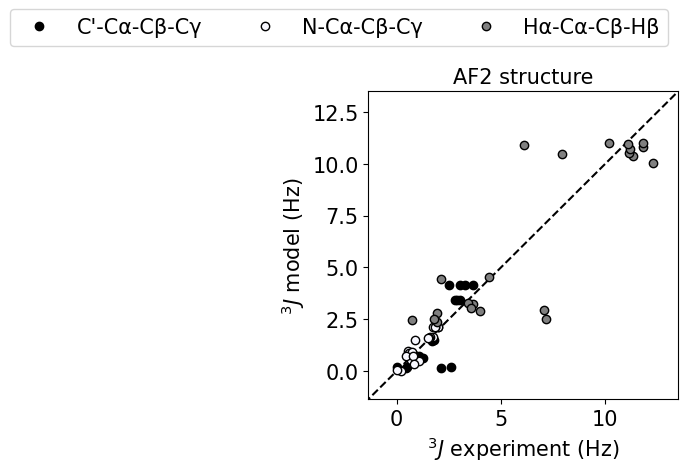

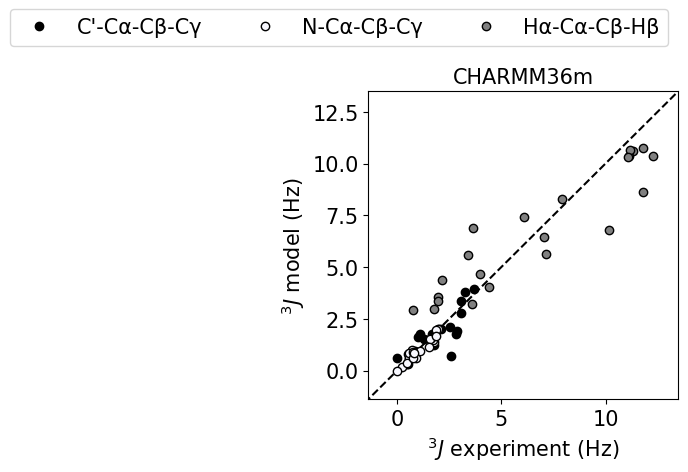

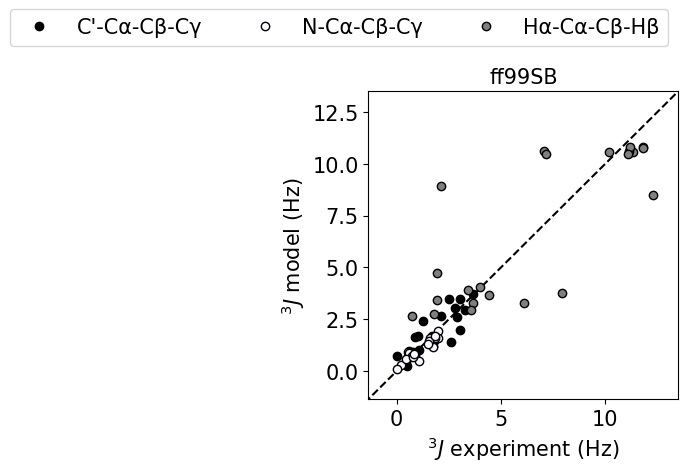

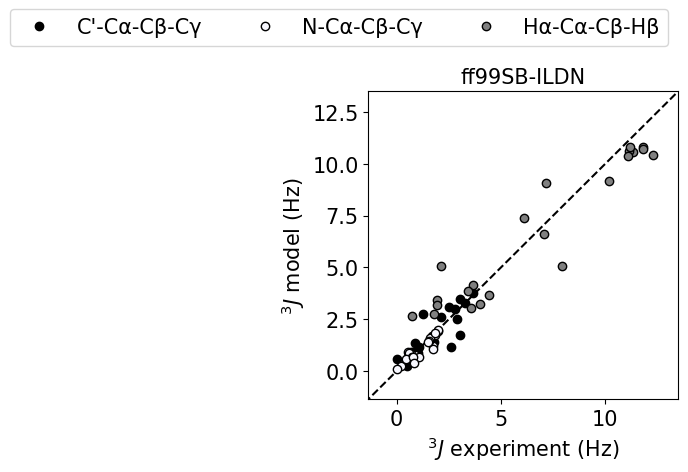

In [21]:
for ensemble_type in j3_results_arrs_C_CA_CB_CG.keys():
    make_plot(np.array(exp_j3_C_CA_CB_CG['exp']), np.array(exp_j3_N_CA_CB_CG['exp']), np.array(exp_j3_HA_CA_CB_HB['exp']), j3_results_arrs_C_CA_CB_CG[ensemble_type], j3_results_arrs_N_CA_CB_CG[ensemble_type], j3_results_arrs_HA_CA_CB_HB[ensemble_type], plot_names_dict[ensemble_type], f'../../figures/gb3_{ensemble_type}_jcouplings.pdf')

# Plot RMSEs split by dihedral type

af2chi 1.6846322937893012 0.23623865248431536
af2chi_prior 2.0575177226324466 0.2682028455695004
af2_structure 2.005438328712698 0.3738843524423388
charmm36m 1.7115248040683941 0.21530949159305826
ff99sb 2.419404509754039 0.45299066146762323
ff99sb_ildn 1.36117763185212 0.18265371926818927


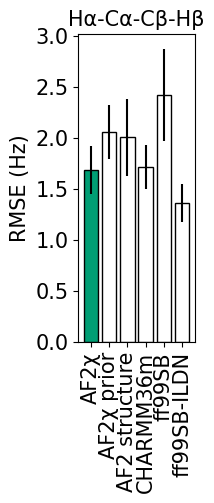

In [22]:
#Plotting
RMSE_arr = []
RMSE_err_arr = []
tick_labels = []
for ensemble_type in j3_results_arrs_HA_CA_CB_HB.keys():
    RMSE = root_mean_squared_error(np.array(exp_j3_HA_CA_CB_HB['exp']), j3_results_arrs_HA_CA_CB_HB[ensemble_type])
    RMSE_arr.append(root_mean_squared_error(np.array(exp_j3_HA_CA_CB_HB['exp']), j3_results_arrs_HA_CA_CB_HB[ensemble_type]))

    bootstrap_result = bootstrap((np.array(exp_j3_HA_CA_CB_HB['exp']), j3_results_arrs_HA_CA_CB_HB[ensemble_type]), root_mean_squared_error, vectorized=False, paired=True)    
    RMSE_err = bootstrap_result.standard_error
    RMSE_err_arr.append(RMSE_err)

    tick_labels.append(plot_names_dict[ensemble_type])

    print(ensemble_type, RMSE, RMSE_err)

x = np.arange(len(RMSE_arr))

fig = plt.figure(figsize=(1.5,4))

plt.bar(x, RMSE_arr, yerr=RMSE_err_arr, edgecolor='black', tick_label=tick_labels, color=[*['#009E74'], *['white']*len(RMSE_arr)])
#plt.axhline(RMSE_arr[0], ls='--', c='k')

plt.title('Hα-Cα-Cβ-Hβ', fontsize=15)

plt.ylabel('RMSE (Hz)', fontsize=15)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)

plt.savefig(f'../../figures/gb3_RMSEjcouplings_HA_CA_CB_HB_bar.pdf', bbox_inches='tight')

af2chi 0.6712274182279652 0.1693473131660393
af2chi_prior 0.7111170214089407 0.16735658699038608
af2_structure 0.890727738904612 0.1828666607718669
charmm36m 0.6156738333026996 0.13560042290197433
ff99sb 0.5948108943185221 0.08376027479999124
ff99sb_ildn 0.6055457986690308 0.12208934455203571


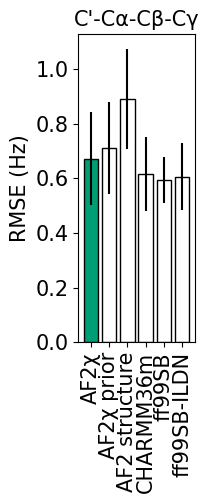

In [23]:
#Plotting
RMSE_arr = []
RMSE_err_arr = []
tick_labels = []
for ensemble_type in j3_results_arrs_C_CA_CB_CG.keys():
    RMSE = root_mean_squared_error(np.array(exp_j3_C_CA_CB_CG['exp']), j3_results_arrs_C_CA_CB_CG[ensemble_type])
    RMSE_arr.append(root_mean_squared_error(np.array(exp_j3_C_CA_CB_CG['exp']), j3_results_arrs_C_CA_CB_CG[ensemble_type]))

    bootstrap_result = bootstrap((np.array(exp_j3_C_CA_CB_CG['exp']), j3_results_arrs_C_CA_CB_CG[ensemble_type]), root_mean_squared_error, vectorized=False, paired=True)    
    RMSE_err = bootstrap_result.standard_error
    RMSE_err_arr.append(RMSE_err)
        
    tick_labels.append(plot_names_dict[ensemble_type])
    
    print(ensemble_type, RMSE, RMSE_err)

x = np.arange(len(RMSE_arr))

fig = plt.figure(figsize=(1.5,4))

plt.bar(x, RMSE_arr, yerr=RMSE_err_arr, edgecolor='black', tick_label=tick_labels, color=[*['#009E74'], *['white']*len(RMSE_arr)])
#plt.axhline(RMSE_arr[0], ls='--', c='k')

plt.title('C\'-Cα-Cβ-Cγ', fontsize=15)

plt.ylabel('RMSE (Hz)', fontsize=15)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)

plt.savefig(f'../../figures/gb3_RMSEjcouplings_C_CA_CB_CG_bar.pdf', bbox_inches='tight')

af2chi 0.2047123380731989 0.02530751865466824
af2chi_prior 0.22325381566794694 0.032819555618984496
af2_structure 0.2945190494092593 0.041034565870268415
charmm36m 0.19571747280259802 0.025511560995520818
ff99sb 0.27577596152018213 0.04527383282988625
ff99sb_ildn 0.2618250961087973 0.04838584504529135


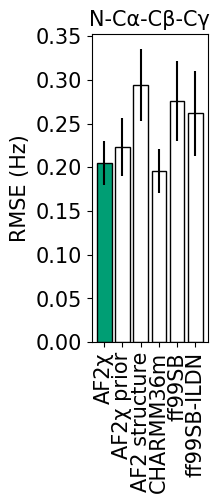

In [24]:
#Plotting
RMSE_arr = []
RMSE_err_arr = []
tick_labels = []
for ensemble_type in j3_results_arrs_N_CA_CB_CG.keys():
    RMSE = root_mean_squared_error(np.array(exp_j3_N_CA_CB_CG['exp']), j3_results_arrs_N_CA_CB_CG[ensemble_type])
    RMSE_arr.append(root_mean_squared_error(np.array(exp_j3_N_CA_CB_CG['exp']), j3_results_arrs_N_CA_CB_CG[ensemble_type]))

    bootstrap_result = bootstrap((np.array(exp_j3_N_CA_CB_CG['exp']), j3_results_arrs_N_CA_CB_CG[ensemble_type]), root_mean_squared_error, vectorized=False, paired=True)    
    RMSE_err = bootstrap_result.standard_error
    RMSE_err_arr.append(RMSE_err)
        
    tick_labels.append(plot_names_dict[ensemble_type])

    print(ensemble_type, RMSE, RMSE_err)

x = np.arange(len(RMSE_arr))

fig = plt.figure(figsize=(1.5,4))

plt.bar(x, RMSE_arr, yerr=RMSE_err_arr, edgecolor='black', tick_label=tick_labels, color=[*['#009E74'], *['white']*len(RMSE_arr)])
#plt.axhline(RMSE_arr[0], ls='--', c='k')

plt.title('N-Cα-Cβ-Cγ', fontsize=15)

plt.ylabel('RMSE (Hz)', fontsize=15)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)

plt.savefig(f'../../figures/gb3_RMSEjcouplings_N_CA_CB_CG_bar.pdf', bbox_inches='tight')